In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

## Reflect Tables into SQLALchemy ORM

In [10]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [11]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [12]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [13]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [14]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [15]:
# Create our session (link) from Python to the DB
session = Session(engine)

## Bonus Challenge Assignment: Temperature Analysis II

In [23]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVG, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# For example
# print(calc_temps('2012-02-28', '2012-03-05'))

In [30]:
start = '2016-06-01'
end = '2017-06-24'

input_date_fmt = dt.datetime.strptime(start, "%Y-%m-%d")
start_date = input_date_fmt.strftime("%Y-%m-%d")

if end == ' ':
    end_date = dt.date(2017, 8, 23).strftime("%Y-%m-%d")      # Latest date in the datset
else:
    end_date_fmt = dt.datetime.strptime(end, "%Y-%m-%d")
    end_date = end_date_fmt.strftime("%Y-%m-%d")

# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, maximum, and average temperatures for that range of dates
def calc_temps(start_date, end_date):
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
    filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

stat_results = calc_temps(start_date, end_date)[0]

stat_list = list(np.ravel(stat_results))
stat_dict = {'Temps': stat_list}
stat_dict

{'Temps': [58.0, 74.55308641975309, 87.0]}

In [83]:
# Use the function `calc_temps` to calculate the tmin, tavg, and tmax 
# for a year in the data set

prev_year_start_date = dt.date(2017,8,1)
prev_year_end_date = dt.date(2017,8,7)

tmin, tavg, tmax = calc_temps(prev_year_start_date.strftime("%Y-%m-%d"), prev_year_end_date.strftime("%Y-%m-%d"))[0]
print(tmin, tavg, tmax)

72.0 79.25 83.0


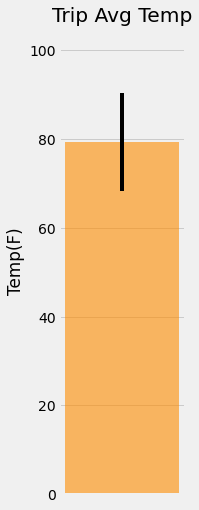

In [106]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for bar height (y value)
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

x_pos = [0]
err = tmax-tmin

fig, ax = plt.subplots(figsize=(2,8))
ax.bar(x_pos, tavg, yerr=err, align='center', alpha=0.6, color = 'darkorange', ecolor='black')
ax.set_ylabel('Temp(F)')
ax.set_title('Trip Avg Temp')
ax.set_ylim(0,105)
ax.tick_params(axis='x', labelbottom=False)
ax.grid(axis ='x')
plt.show();

### Daily Rainfall Average

In [122]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's 
# matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

prev_year_start_date = dt.date(2017,8,1)
prev_year_end_date = dt.date(2017,8,7)

sel = [Measurement.station, Station.name, Station.latitude, Station.longitude, Station.elevation,
      func.sum(Measurement.prcp)]

station_rainfalls = session.query(*sel).\
                     filter(Measurement.date >=prev_year_start_date).\
                     filter(Measurement.date <=prev_year_end_date).\
                     filter(Measurement.station == Station.station).\
                     group_by(Measurement.station).\
                     order_by(func.sum(Measurement.prcp).desc()).all()

for station_rainfall in station_rainfalls:
    print(station_rainfall)

('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 21.3331, -157.8025, 152.4, 0.36)
('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 21.5213, -157.8374, 7.0, 0.22)
('USC00519281', 'WAIHEE 837.5, HI US', 21.45167, -157.84888999999998, 32.9, 0.06)
('USC00519397', 'WAIKIKI 717.2, HI US', 21.2716, -157.8168, 3.0, 0.04)
('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 21.33556, -157.71139, 19.5, 0.0)


In [123]:
# Use this function to calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()

# For example
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [159]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
start_date = '2017-08-01'
end_date = '2017-08-07'

# Use the start and end date to create a range of dates
start_date_time = dt.datetime.strptime(start_date, "%Y-%m-%d")
end_date_time = dt.datetime.strptime(end_date, "%Y-%m-%d")

date_generated = [start_date_time + dt.timedelta(days=x) for x in range(0, (end_date_time.day))]

# Strip off the year and save a list of strings in the format %m-%d
date_mm_dd = []
normals = []

for date_stripe in date_generated:
    date_mm_dd.append(date_stripe.strftime("%m-%d"))

# Use the `daily_normals` function to calculate the normals for each date string 
# and append the results to a list called `normals`.
for mm_dd in date_mm_dd:
    normals.append(daily_normals(mm_dd)[0])

normals

[(67.0, 75.54, 83.0),
 (68.0, 75.60377358490567, 84.0),
 (70.0, 76.61111111111111, 85.0),
 (69.0, 76.71153846153847, 84.0),
 (69.0, 76.14814814814815, 82.0),
 (67.0, 76.25, 83.0),
 (71.0, 77.15686274509804, 83.0)]

In [170]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns=['Min', 'Avg', 'Max'])
normals_df['date'] = date_generated
normals_df = normals_df.set_index('date')
normals_df

,Min,Avg,Max
date,,,
2017-08-01,67.0,75.540000,83.0
2017-08-02,68.0,75.603774,84.0
2017-08-03,70.0,76.611111,85.0
2017-08-04,69.0,76.711538,84.0
2017-08-05,69.0,76.148148,82.0
2017-08-06,67.0,76.250000,83.0
2017-08-07,71.0,77.156863,83.0


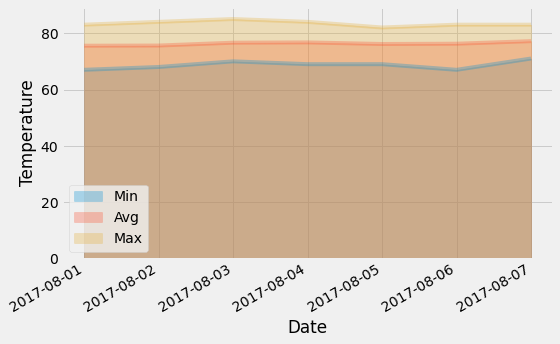

In [201]:
# Plot the daily normals as an area plot with `stacked=False`


normals_df.plot(kind='area', stacked=False, x_compat=True, figsize=(8,5), alpha = 0.3)
plt.xlabel('Date')
plt.ylabel('Temperature')
plt.grid('True', axis='both')
plt.legend(loc='lower left')
plt.tight_layout();

## Close Session

In [ ]:
session.close()